Importar todas las librerias necesarias para correr el script

In [3]:
# Para cargar el Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Para manejar los datos mas facilmente con pandas
import pandas as pd

# Para ejecutar el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Para evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

Cargue del Dataset, conversion a Dataframe e impresión de las primeras 5 lineas

In [4]:
# Ruta relativa del archivo dentro del dataset
file_path = "cs448b_ipasn.csv"

# Cargar el dataset directamente como DataFrame
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "crawford/computer-network-traffic",
    file_path
)

# Ver los primeros registros
print("Primeras 5 filas:")
print(df.head())


C:\Users\onnyx\AppData\Local\Temp\ipykernel_29424\322194670.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Primeras 5 filas:
         date  l_ipn  r_asn  f
0  2006-07-01      0    701  1
1  2006-07-01      0    714  1
2  2006-07-01      0   1239  1
3  2006-07-01      0   1680  1
4  2006-07-01      0   2514  1


Convertir la fecha y agregar etiquetas sobre los casos comprometidos

In [5]:
# Convertir la columna 'date' a formato datetime, el cual es un formato legible y comparable por python
df['date'] = pd.to_datetime(df['date'])

# Definir fechas de compromiso por IP local (l_ipn), estas son IP determinadas como comprometidas en la fecha en la que se empezaron a considerar comprometidas
compromised_dates = {
    1: '2006-08-24',
    5: '2006-09-04',
    4: '2006-09-18',
    3: '2006-09-26',
    6: '2006-09-26'
}

# Crear la columna 'compromised'
# Se agrega un parámetro de comprometido al dataframe, el cual funciona como un booleano, se marca 1 para comprometida y 0 a no comprometida. 
def label_compromised(row):
    ip = row['l_ipn']
    date = row['date']
    if ip in compromised_dates and date >= pd.to_datetime(compromised_dates[ip]):
        return 1
    return 0

df['compromised'] = df.apply(label_compromised, axis=1)


Procesamiento del dataset

In [6]:
# Normalizar la cantidad de flujos (f)
# Para este caso, la normalizacion consiste en transformar los valores de la cantidad de flujos de red por día específico (f) 
# convirtiendo esta información en un rango de 0 a 1 para facilitar la comprensión de los valores
df['f_norm'] = (df['f'] - df['f'].min()) / (df['f'].max() - df['f'].min())

# Variables para entrenamiento
# Se toman las variables x para las variables independientes que en este caso sería el flujo de conexiones normalizado
# Tambien se toma la variable dependiente y que sería correspondiente a si la IP está comprometida o no posterior a la fecha determinada
X = df[['f_norm']]
y = df['compromised']


Dividir los datos y entrenar el modelo

In [7]:
# Dividir en entrenamiento y prueba
# En este caso se divide el dataset en 75% datos de entrenamiento y 25% datos de prueba para entrenar el modelo y probarlo con los datos que no ha visto
# random_state Permite reproducir la misma división de datos cada vez que se corra el código, es como una semilla para "mantener la aleatoriedad controlada".
# stratify Asegura que la proporción de clases se mantenga en train y test, de modo que no exista un desbalance entre los datos de prueba y entrenamiento con respecto a la variable dependiente.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Entrenar modelo de regresión logística
# Se crea y se entrena tambien el modelo, en este caso de regresión logística del cual buscamos que aprenda una relacion entre f_norm y la probabilidad de que la IP estuviera o no comprometida
model = LogisticRegression(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Predicciones
# Se definen las variables y_pred correspondiente a los valores finales de predicción 
# y "y_prob" la cual es la probabilidad de que cada fila esté comprometida con valores entre 0 y 1 
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


Evaluacion del modelo

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5138
           1       0.00      0.00      0.00        63

    accuracy                           0.98      5201
   macro avg       0.49      0.50      0.50      5201
weighted avg       0.98      0.98      0.98      5201

Matriz de confusión:
 [[5117   21]
 [  63    0]]


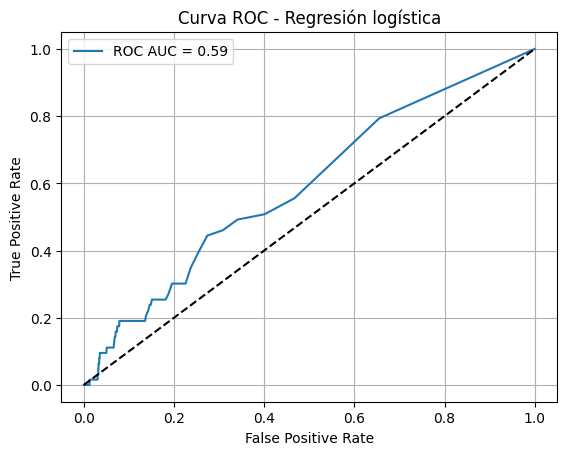

In [ ]:

# Reporte de clasificación
# Se ejecutan una serie de métricas importadas al inicio, con las cuales se puede identificar la presicion, sensibilidad, score y la matriz de confusion

print("Reporte de clasificación:\n",classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# Curva ROC
# Esta curva ayuda a determinar que tan bien separa el modelo casos comprometidos de casos normales
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Esto último se encarga de presentar o dibujar la curva ROC
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión logística")
plt.legend()
plt.grid()
plt.show()
